# Use an scVI run to created "de-batched" count data for use downstream

2024.04.26

Run scVI using Cellarium ML and explore the outputs.

In [1]:
# your config file for running scVI

config_file = "example_configs/scvi_sanger_heart_config.yaml"

## Run scVI

In [ ]:
!cellarium-ml scvi fit --config {config_file}

## Load model

In [5]:
# your latest checkpoint file (you'll need to look for it)

checkpoint_file = 'lightning_logs/version_81/checkpoints/epoch=49-step=29800.ckpt'

In [3]:
from cellarium.ml.core import CellariumPipeline, CellariumModule
from cellarium.ml.data import (
    DistributedAnnDataCollection,
    IterableDistributedAnnDataCollectionDataset,
)
from cellarium.ml.data.fileio import read_h5ad_file
from cellarium.ml.utilities.data import AnnDataField, densify, categories_to_codes

import torch
import numpy as np
import anndata
import scanpy as sc
import scipy.sparse as sp
import tqdm
import umap
import matplotlib.pyplot as plt

import tempfile
import os
import yaml

%matplotlib inline

/home/sfleming/miniforge3/envs/cellarium/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/sfleming/miniforge3/envs/cellarium/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/sfleming/miniforge3/envs/cellarium/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [6]:
# load the trained model
scvi_model = CellariumModule.load_from_checkpoint(checkpoint_file).model

# move the model to the correct device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
scvi_model.to(device)
scvi_model.eval()

# construct the pipeline
pipeline = CellariumPipeline([scvi_model])

/home/sfleming/miniforge3/envs/cellarium/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [11]:
class AutosizedDistributedAnnDataCollection(DistributedAnnDataCollection):

    def __init__(self, *args, **kwargs):
        # I'm being lazy here and doing something real ugly
        # I want it to take the shard_size from the first file
        try:
            # this allows super to find the list of filenames
            super().__init__(*args, **kwargs)
        except AssertionError:
            try:
                # this allows super to create the cache
                kwargs.pop("shard_size")
                kwargs = kwargs | {"shard_size": 10000}
                super().__init__(*args, **kwargs)
            except AssertionError:
                pass
            # load first file and cache it
            adata0 = self.cache[self.filenames[0]] = read_h5ad_file(self.filenames[0])
            # pull shard_size from that file
            kwargs.pop("shard_size")
            kwargs = kwargs | {"shard_size": len(adata0)}
            # finally initialize for real
            super().__init__(*args, **kwargs)


def get_dataset_from_anndata(
    adata: anndata.AnnData | str, 
    batch_size: int = 128, 
    shard_size: int | None = None, 
    shuffle: bool = False, 
    seed: int = 0, 
    obs_batch_key: str = 'batch',
    drop_last: bool = False,
):
    """
    Get IterableDistributedAnnDataCollectionDataset from an AnnData object or h5ad file specifier.

    Args:
        adata: AnnData object or h5ad file, allowing brace notation for several files.
        batch_size: Batch size.
        shard_size: Shard size.
        shuffle: Whether to shuffle the dataset.
        seed: Random seed.
        obs_batch_key: key for batch labels
        drop_last: Whether to drop the last incomplete batch.

    Returns:
        IterableDistributedAnnDataCollectionDataset.
    """

    if isinstance(adata, anndata.AnnData):
        tmpfile = tempfile.mkstemp(suffix='.h5ad')
        adata.write(tmpfile[1])
        file = tmpfile[1]
    else:
        file = adata

    dadc = AutosizedDistributedAnnDataCollection(
        file,
        shard_size=shard_size,
        max_cache_size=1,
    )

    dataset = IterableDistributedAnnDataCollectionDataset(
        dadc,
        batch_keys={
            "x_ng": AnnDataField(attr="X", convert_fn=densify),
            "var_names_g": AnnDataField(attr="var_names"),
            "batch_index_n": AnnDataField(attr="obs", key=obs_batch_key, convert_fn=categories_to_codes),
        },
        batch_size=batch_size,
        shuffle=shuffle,
        seed=seed,
        drop_last=drop_last,
    )
    return dataset

In [17]:
# get the location of the dataset
with open(config_file, "r") as file:
    config_dict = yaml.safe_load(file)
data_path = config_dict['data']['dadc']['init_args']['filenames']
print(f'Data is coming from {data_path}')

# get a dataset object
dataset = get_dataset_from_anndata(
    data_path, 
    batch_size=128, 
    shuffle=False, 
    seed=0, 
    obs_batch_key=config_dict['data']['batch_keys']['batch_index_n']['key'],
    drop_last=False,
)

Data is coming from /home/sfleming/cellarium-ml/data/Lake_kidney_2023_hvg_glyco.h5ad


In [103]:
def reconstruct_debatched(
    dataset: IterableDistributedAnnDataCollectionDataset, 
    pipeline: CellariumPipeline, 
    transform_to_batch_label: int,
    maximum_anndata_files_to_download: int = 5,
    layer_key_added: str = 'scvi_reconstructed',
) -> anndata.AnnData:
    """
    Reconstruct the dataset using the pipeline.

    Args:
        dataset: Dataset.
        pipeline: Pipeline.
        transform_to_batch_label: batch label to reconstruct as
        maximum_anndata_files_to_download: Maximum number of anndata files to download.
        layer_key_added: Output counts will be stored in adata.layers[layer_key_added]

    Returns:
        AnnData with scVI reconstruction in adata.layers[layer_key_added]
    """

    # get the anndata object
    adatas = [dataset.dadc.adatas[i].adata for i in range(min(maximum_anndata_files_to_download, len(dataset.dadc.adatas)))]
    adata = anndata.concat(adatas, axis=0, merge="same")

    scvi_model = pipeline[-1]

    # run the pipeline
    sparse_coos = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataset):
            batch['x_ng'] = torch.from_numpy(batch['x_ng']).to(device)
            batch['batch_index_n'] = torch.from_numpy(batch['batch_index_n']).to(device)
            # out = pipeline.predict(batch)
            counts_ng = scvi_model.reconstruct(
                x_ng=batch['x_ng'] ,
                var_names_g=batch['var_names_g'],
                batch_index_n=batch['batch_index_n'],
                transform_batch=transform_to_batch_label,
                sample=False,
            )
            sparse_coos.append(sp.coo_matrix(counts_ng.cpu().numpy()))

    # make the final sparse matrix and keep it as a layer
    csr = sp.vstack(sparse_coos).tocsr()
    adata.layers[layer_key_added] = csr

    return adata

In [104]:
adata = None

for label in [0]:  # range(pipeline[-1].n_batch):
    adata_tmp = reconstruct_debatched(dataset, pipeline, transform_to_batch_label=label, layer_key_added=f'scvi_reconstructed_{label}')
    if adata is None:
        adata = adata_tmp  # reconstruct_debatched(dataset, pipeline, transform_to_batch_label=label, layer_key_added=f'scvi_reconstructed_{label}')
    else:
        # reconstruct_debatched(dataset, pipeline, transform_to_batch_label=label, layer_key_added=f'scvi_reconstructed_{label}')
        adata.layers[f'scvi_reconstructed_{label}'] = adata_tmp.layers[f'scvi_reconstructed_{label}']
    break

/home/sfleming/cellarium-ml/cellarium/ml/utilities/data.py:99: UserWarning: Distributed package is available but the default process group has not been initialized. Falling back to ``rank=0`` and ``num_replicas=1``.
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2381/2381 [03:48<00:00, 10.41it/s]


In [105]:
adata

AnnData object with n_obs × n_vars = 304652 × 2109
    obs: 'nCount_RNA', 'nFeature_RNA', 'library', 'percent.er', 'percent.mt', 'degen.score', 'aEpi.score', 'aStr.score', 'cyc.score', 'matrisome.score', 'collagen.score', 'glycoprotein.score', 'proteoglycan.score', 'S.Score', 'G2M.Score', 'experiment', 'specimen', 'condition.long', 'condition.l1', 'condition.l2', 'donor_id', 'region.l1', 'region.l2', 'percent.cortex', 'percent.medulla', 'sample_tissue_type', 'id', 'pagoda_k100_infomap_coembed', 'subclass.full', 'subclass.l3', 'subclass.l2', 'subclass.l1', 'state.l2', 'state', 'class', 'structure', 'disease_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'eGFR', 'BMI', 'diabetes_history', 'hypertension', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 

In [106]:
adata.layers['raw'] = adata.X.copy()

In [107]:
adata

AnnData object with n_obs × n_vars = 304652 × 2109
    obs: 'nCount_RNA', 'nFeature_RNA', 'library', 'percent.er', 'percent.mt', 'degen.score', 'aEpi.score', 'aStr.score', 'cyc.score', 'matrisome.score', 'collagen.score', 'glycoprotein.score', 'proteoglycan.score', 'S.Score', 'G2M.Score', 'experiment', 'specimen', 'condition.long', 'condition.l1', 'condition.l2', 'donor_id', 'region.l1', 'region.l2', 'percent.cortex', 'percent.medulla', 'sample_tissue_type', 'id', 'pagoda_k100_infomap_coembed', 'subclass.full', 'subclass.l3', 'subclass.l2', 'subclass.l1', 'state.l2', 'state', 'class', 'structure', 'disease_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'eGFR', 'BMI', 'diabetes_history', 'hypertension', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 

# Visualizations

In [27]:
sc.set_figure_params(fontsize=14, vector_friendly=True)

## Before scVI

In [28]:
for layer in adata.layers.keys():
    if not layer.startswith('scvi_reconstructed'):
        continue

    print(f'working on {layer}')
    adata.X = adata.layers[layer].copy()

    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata, n_pcs=20, n_neighbors=15, metric='euclidean', method='umap')
    sc.tl.umap(adata)
    adata.obsm[f'X_{layer}_umap'] = adata.obsm['X_umap'].copy()

working on scvi_reconstructed_0


In [29]:
adata

AnnData object with n_obs × n_vars = 304652 × 2109
    obs: 'nCount_RNA', 'nFeature_RNA', 'library', 'percent.er', 'percent.mt', 'degen.score', 'aEpi.score', 'aStr.score', 'cyc.score', 'matrisome.score', 'collagen.score', 'glycoprotein.score', 'proteoglycan.score', 'S.Score', 'G2M.Score', 'experiment', 'specimen', 'condition.long', 'condition.l1', 'condition.l2', 'donor_id', 'region.l1', 'region.l2', 'percent.cortex', 'percent.medulla', 'sample_tissue_type', 'id', 'pagoda_k100_infomap_coembed', 'subclass.full', 'subclass.l3', 'subclass.l2', 'subclass.l1', 'state.l2', 'state', 'class', 'structure', 'disease_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'eGFR', 'BMI', 'diabetes_history', 'hypertension', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 

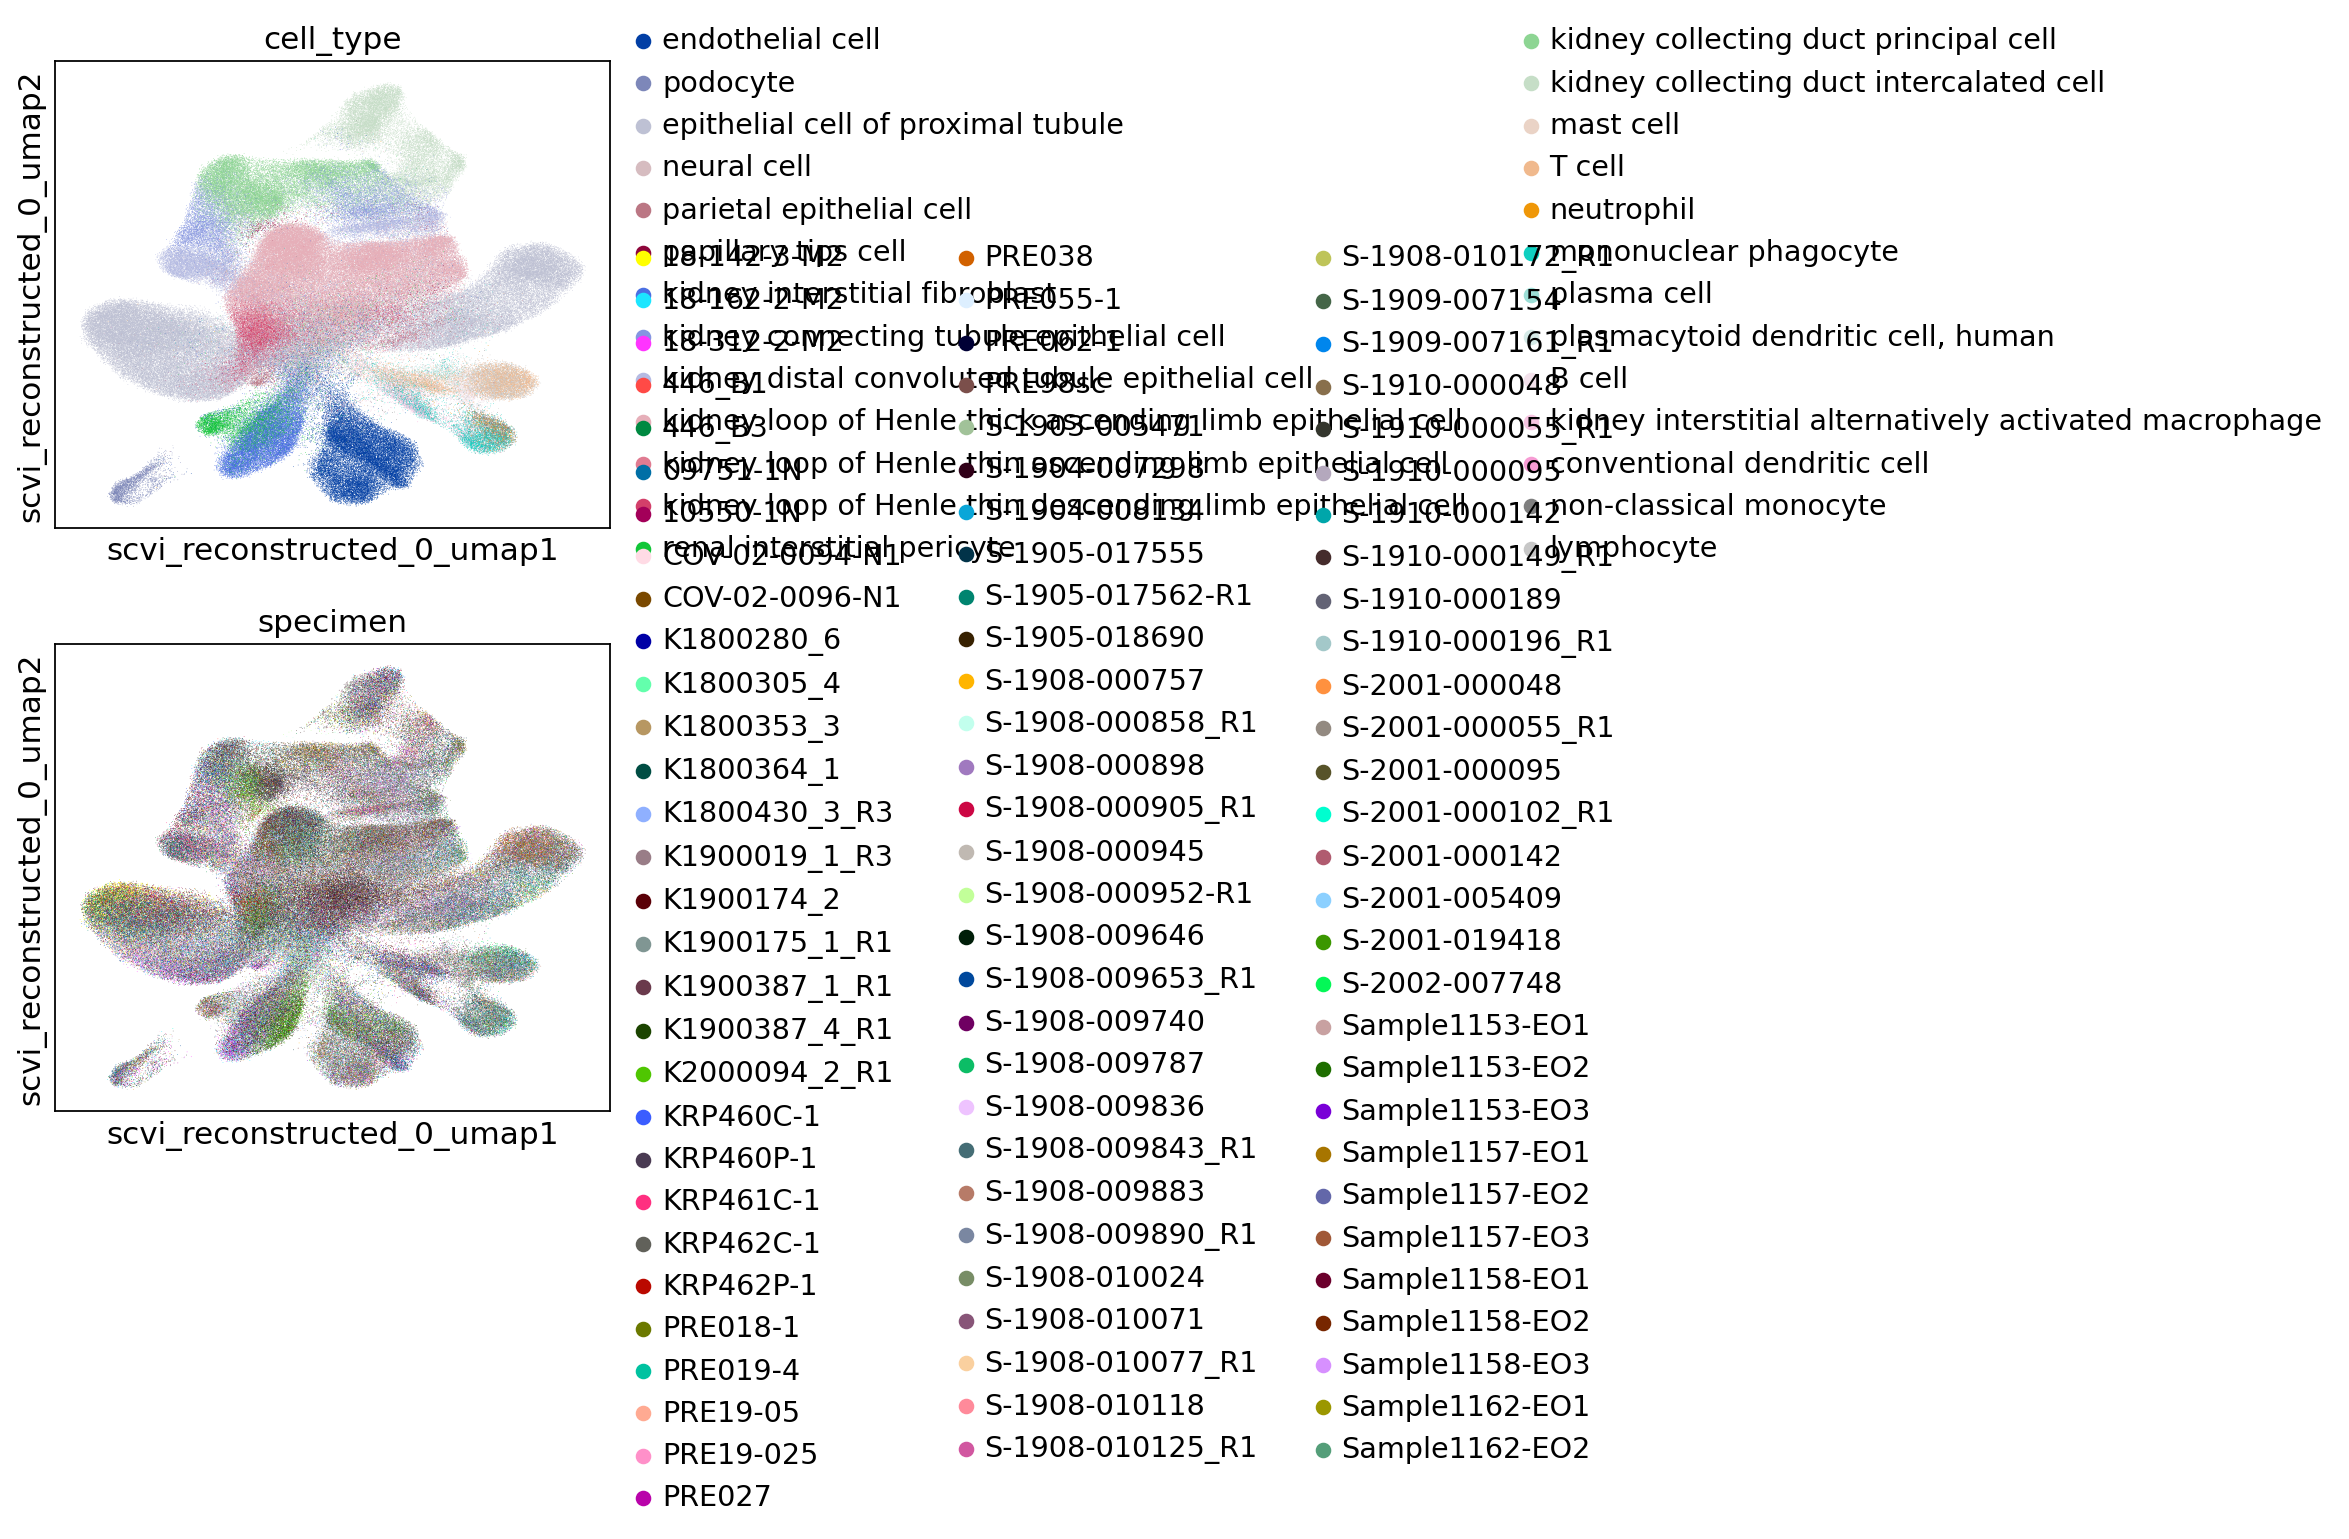

In [32]:
sc.pl.embedding(adata, basis='scvi_reconstructed_0_umap', color=['cell_type', 'specimen'], ncols=1)

In [109]:
gene_set_dict = {
    'dpy19l':['DPY19L1', 'DPY19L2', 'DPY19L3', 'DPY19L4'],
    'piga':['PGAP4', 'PIGA', 'PIGB', 'PIGM', 'PIGV', 'PIGZ'],
    'ugcg':['A4GALT', 'B3GALNT1', 'B3GALT4', 'B3GNT5', 'B4GALNT1', 'B4GALT5', 'B4GALT6', 'UGCG'],
    'ugt8':['UGT8'],
    'ost':['ALG10', 'ALG10B', 'ALG11', 'ALG12', 'ALG13', 'ALG14', 'ALG2', 'ALG3', 'ALG6', 'ALG8', 'ALG9', 'DPAGT1', 'FUT8', 'MGAT1', 'MGAT2', 'MGAT3', 'MGAT4A', 'MGAT4B', 'MGAT4C', 'MGAT4D', 'MGAT5', 'STT3A', 'UGGT1', 'UGGT2'],
    'ogt':['OGT'],
    'colgalt':['COLGALT1', 'COLGALT2'],
    'eogt':['EOGT'],
    'galnt':['B3GNT6', 'C1GALT1', 'C1GALT1C1', 'GALNT1', 'GALNT10', 'GALNT11', 'GALNT12', 'GALNT13', 'GALNT14', 'GALNT15', 'GALNT16', 'GALNT17', 'GALNT18', 'GALNT2', 'GALNT3', 'GALNT4', 'GALNT5', 'GALNT6', 'GALNT7', 'GALNT8', 'GALNT9', 'GCNT1', 'GCNT3', 'GCNT4'],
    'pofut1':['LFNG', 'MFNG', 'POFUT1', 'RFNG'],
    'pofut2':['B3GLCT', 'POFUT2'],
    'poglut':['GXYLT1', 'GXYLT2', 'POGLUT1', 'POGLUT2', 'POGLUT3', 'XXYLT1'],
    'pomt':['B3GALNT2', 'B4GAT1', 'FKRP', 'FKTN', 'LARGE1', 'LARGE2', 'MGAT5B', 'POMGNT1', 'POMGNT2', 'POMK', 'POMT1', 'POMT2', 'RXYLT1'],
    'tmtc':['TMTC1', 'TMTC2', 'TMTC3', 'TMTC4', 'TMEM260'],
    'xylt1/2':['B3GALT6', 'B3GAT3', 'B4GALT7', 'CHPF', 'CHPF2', 'CHSY1', 'CHSY3', 'CSGALNACT1', 'CSGALNACT2', 'EXT1', 'EXT2', 'EXTL1', 'EXTL2', 'EXTL3', 'XYLT1', 'XYLT2']
}

glyco_gene_list = [a for b in gene_set_dict.values() for a in b]

adata.var['glyco_gene'] = adata.var['feature_name'].isin(glyco_gene_list)
adata.var['glyco_gene'].sum()

117

In [110]:
for layer in adata.layers.keys():
    if not layer.startswith('scvi_reconstructed'):
        continue

    print(f'working on {layer}')
    adata.X = adata.layers[layer].copy()

    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.pca(adata, mask_var='glyco_gene')
    sc.pp.neighbors(adata, n_pcs=20, n_neighbors=15, metric='euclidean', method='umap')
    sc.tl.umap(adata)
    adata.obsm[f'X_{layer}_geneset_umap'] = adata.obsm['X_umap'].copy()

    break

working on scvi_reconstructed_0


In [111]:
adata

AnnData object with n_obs × n_vars = 304652 × 2109
    obs: 'nCount_RNA', 'nFeature_RNA', 'library', 'percent.er', 'percent.mt', 'degen.score', 'aEpi.score', 'aStr.score', 'cyc.score', 'matrisome.score', 'collagen.score', 'glycoprotein.score', 'proteoglycan.score', 'S.Score', 'G2M.Score', 'experiment', 'specimen', 'condition.long', 'condition.l1', 'condition.l2', 'donor_id', 'region.l1', 'region.l2', 'percent.cortex', 'percent.medulla', 'sample_tissue_type', 'id', 'pagoda_k100_infomap_coembed', 'subclass.full', 'subclass.l3', 'subclass.l2', 'subclass.l1', 'state.l2', 'state', 'class', 'structure', 'disease_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'eGFR', 'BMI', 'diabetes_history', 'hypertension', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 

In [51]:
for i in range(adata.varm['PCs'].shape[1]):
    adata.var[f'pc{i}'] = adata.varm['PCs'][:, i].squeeze()

In [52]:
adata.var.sort_values(by='pc0', ascending=False)

,feature_is_filtered,feature_reference,feature_biotype,feature_length,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches,...,pc40,pc41,pc42,pc43,pc44,pc45,pc46,pc47,pc48,pc49
feature_name,,,,,,,,,,,,,,,,,,,,,
EXT1,False,NCBITaxon:9606,gene,10736,False,1167.5,1.570622,11.647064,0.973874,2,...,0.005106,-0.007537,-0.000288,0.003917,-0.007363,-0.005358,0.001096,0.006646,0.004541,-0.009948
TMTC2,False,NCBITaxon:9606,gene,8323,False,797.0,1.275012,17.920446,1.527080,39,...,0.001272,-0.007325,-0.001528,0.003986,-0.003056,-0.005304,0.000645,0.004011,-0.004337,0.003970
LARGE1,False,NCBITaxon:9606,gene,14081,False,1191.0,0.821347,4.446115,1.024396,4,...,0.011515,-0.006969,-0.002933,0.006435,-0.009058,-0.009929,-0.001819,0.012575,-0.003819,-0.011273
GALNT18,False,NCBITaxon:9606,gene,3626,False,1507.5,0.976652,6.173106,1.102536,8,...,0.000414,-0.007967,-0.002203,-0.003842,-0.006292,-0.004354,-0.005541,0.009414,-0.014412,-0.002172
GALNT14,False,NCBITaxon:9606,gene,4344,False,1519.5,1.055247,8.695422,1.235471,26,...,0.024059,-0.004131,-0.004699,-0.002522,-0.004832,-0.005238,-0.006035,0.002433,-0.021172,0.000782
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B4GAT1,False,NCBITaxon:9606,gene,2007,False,1373.0,0.059931,0.071478,0.910495,1,...,0.060680,0.002436,-0.008154,0.011142,-0.009621,-0.005811,0.049715,0.109031,-0.005470,-0.005777
B3GAT3,False,NCBITaxon:9606,gene,2407,False,NaN,0.148353,0.192427,0.862992,0,...,-0.371679,0.026449,-0.031372,-0.059428,0.007940,-0.002749,-0.029448,-0.081549,0.007462,0.001965
MGAT4B,False,NCBITaxon:9606,gene,5495,False,1657.0,0.160701,0.234762,0.880828,1,...,0.064755,-0.005409,0.004018,0.061008,-0.027886,-0.052531,0.264640,0.891033,-0.070461,0.050190


In [112]:
adata_glyco = adata[:, adata.var['glyco_gene']].copy()
adata_glyco

AnnData object with n_obs × n_vars = 304652 × 117
    obs: 'nCount_RNA', 'nFeature_RNA', 'library', 'percent.er', 'percent.mt', 'degen.score', 'aEpi.score', 'aStr.score', 'cyc.score', 'matrisome.score', 'collagen.score', 'glycoprotein.score', 'proteoglycan.score', 'S.Score', 'G2M.Score', 'experiment', 'specimen', 'condition.long', 'condition.l1', 'condition.l2', 'donor_id', 'region.l1', 'region.l2', 'percent.cortex', 'percent.medulla', 'sample_tissue_type', 'id', 'pagoda_k100_infomap_coembed', 'subclass.full', 'subclass.l3', 'subclass.l2', 'subclass.l1', 'state.l2', 'state', 'class', 'structure', 'disease_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'eGFR', 'BMI', 'diabetes_history', 'hypertension', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', '

In [113]:
from sklearn.decomposition import NMF

In [114]:
nmf = NMF(n_components=5, init='random', random_state=0)
W = nmf.fit_transform(adata_glyco.layers['scvi_reconstructed_0'])

/home/sfleming/miniforge3/envs/cellarium/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [115]:
nmf.components_.shape

(5, 117)

In [116]:
for i in range(nmf.components_.shape[0]):
    adata_glyco.var[f'nmf{i}'] = nmf.components_[i, :].squeeze()

In [117]:
adata_glyco.var.sort_values(by='nmf0', ascending=False).head(10)

,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches,include_scvi,glyco_gene,nmf0,nmf1,nmf2,nmf3,nmf4
ENSG00000179104,False,TMTC2,NCBITaxon:9606,gene,8323,False,797.0,1.275012,17.920446,1.527080,39,True,True,3.186519,0.000000,1.787409,0.000000,0.000000
ENSG00000147408,False,CSGALNACT1,NCBITaxon:9606,gene,7632,False,830.0,0.551649,7.180834,1.501374,40,True,True,1.226091,0.653949,0.000000,1.563340,0.167757
ENSG00000182197,False,EXT1,NCBITaxon:9606,gene,10736,False,1167.5,1.570622,11.647064,0.973874,2,True,True,1.138586,0.269164,1.810046,9.673029,1.218730
ENSG00000158470,False,B4GALT5,NCBITaxon:9606,gene,4722,True,563.0,0.535362,1.641938,0.971063,1,True,True,0.628085,0.066696,1.364493,1.498123,0.403170
ENSG00000110328,False,GALNT18,NCBITaxon:9606,gene,3626,False,1507.5,0.976652,6.173106,1.102536,8,True,True,0.567598,0.000000,3.272818,0.000000,0.568218
ENSG00000178234,False,GALNT11,NCBITaxon:9606,gene,8288,False,1424.0,0.555690,1.381148,1.014612,15,True,True,0.565769,0.099363,0.728258,0.568010,0.131046
ENSG00000131873,False,CHSY1,NCBITaxon:9606,gene,5667,False,1478.0,0.233663,0.588498,1.048790,7,True,True,0.556559,0.229545,0.000000,1.081743,0.146136
ENSG00000133424,False,LARGE1,NCBITaxon:9606,gene,14081,False,1191.0,0.821347,4.446115,1.024396,4,True,True,0.371778,0.872576,1.885526,2.575154,1.811954
ENSG00000147162,False,OGT,NCBITaxon:9606,gene,9803,False,NaN,0.478011,0.847021,0.805788,0,True,True,0.366795,0.995722,0.306246,1.054176,0.365013
ENSG00000102595,False,UGGT2,NCBITaxon:9606,gene,8091,False,1246.0,0.540492,1.331483,0.860746,1,True,True,0.325118,0.142225,0.978487,1.322538,0.518376


In [118]:
adata_glyco.var.sort_values(by='nmf1', ascending=False).head(10)

,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches,include_scvi,glyco_gene,nmf0,nmf1,nmf2,nmf3,nmf4
ENSG00000033170,False,FUT8,NCBITaxon:9606,gene,6976,False,1695.0,0.413908,1.408126,1.115150,11,True,True,0.000000,4.956734,0.209111,0.000000,0.000000
ENSG00000143641,False,GALNT2,NCBITaxon:9606,gene,7712,False,NaN,0.337168,0.811793,0.921058,0,True,True,0.148625,1.274944,2.689131,0.238842,0.152486
ENSG00000103489,False,XYLT1,NCBITaxon:9606,gene,11083,False,945.0,0.186084,1.075991,1.410317,37,True,True,0.000000,1.098139,0.000000,1.691518,0.325614
ENSG00000131446,False,MGAT1,NCBITaxon:9606,gene,11499,False,NaN,0.145491,0.189887,0.895328,0,True,True,0.047235,1.067693,0.058805,0.000000,0.192536
ENSG00000147162,False,OGT,NCBITaxon:9606,gene,9803,False,NaN,0.478011,0.847021,0.805788,0,True,True,0.366795,0.995722,0.306246,1.054176,0.365013
ENSG00000133424,False,LARGE1,NCBITaxon:9606,gene,14081,False,1191.0,0.821347,4.446115,1.024396,4,True,True,0.371778,0.872576,1.885526,2.575154,1.811954
ENSG00000123989,False,CHPF,NCBITaxon:9606,gene,3703,False,1668.0,0.103889,0.165126,1.029858,7,True,True,0.082854,0.822983,0.000000,0.000000,0.055925
ENSG00000147408,False,CSGALNACT1,NCBITaxon:9606,gene,7632,False,830.0,0.551649,7.180834,1.501374,40,True,True,1.226091,0.653949,0.000000,1.563340,0.167757
ENSG00000148154,False,UGCG,NCBITaxon:9606,gene,4567,False,1323.0,0.521467,2.261954,1.289130,35,True,True,0.120582,0.427382,2.035328,1.327723,0.048830
ENSG00000136731,False,UGGT1,NCBITaxon:9606,gene,11349,False,NaN,0.181991,0.235751,0.845392,0,True,True,0.102724,0.398755,0.192351,0.369205,0.190247


In [119]:
adata_glyco.var.sort_values(by='nmf2', ascending=False).head(10)

,feature_is_filtered,feature_name,feature_reference,feature_biotype,feature_length,highly_variable,highly_variable_rank,means,variances,variances_norm,highly_variable_nbatches,include_scvi,glyco_gene,nmf0,nmf1,nmf2,nmf3,nmf4
ENSG00000158089,False,GALNT14,NCBITaxon:9606,gene,4344,False,1519.5,1.055247,8.695422,1.235471,26,True,True,0.000000,0.000000,6.815924,0.000000,0.053952
ENSG00000110328,False,GALNT18,NCBITaxon:9606,gene,3626,False,1507.5,0.976652,6.173106,1.102536,8,True,True,0.567598,0.000000,3.272818,0.000000,0.568218
ENSG00000143641,False,GALNT2,NCBITaxon:9606,gene,7712,False,NaN,0.337168,0.811793,0.921058,0,True,True,0.148625,1.274944,2.689131,0.238842,0.152486
ENSG00000148154,False,UGCG,NCBITaxon:9606,gene,4567,False,1323.0,0.521467,2.261954,1.289130,35,True,True,0.120582,0.427382,2.035328,1.327723,0.048830
ENSG00000133424,False,LARGE1,NCBITaxon:9606,gene,14081,False,1191.0,0.821347,4.446115,1.024396,4,True,True,0.371778,0.872576,1.885526,2.575154,1.811954
ENSG00000182197,False,EXT1,NCBITaxon:9606,gene,10736,False,1167.5,1.570622,11.647064,0.973874,2,True,True,1.138586,0.269164,1.810046,9.673029,1.218730
ENSG00000179104,False,TMTC2,NCBITaxon:9606,gene,8323,False,797.0,1.275012,17.920446,1.527080,39,True,True,3.186519,0.000000,1.787409,0.000000,0.000000
ENSG00000158470,False,B4GALT5,NCBITaxon:9606,gene,4722,True,563.0,0.535362,1.641938,0.971063,1,True,True,0.628085,0.066696,1.364493,1.498123,0.403170
ENSG00000102595,False,UGGT2,NCBITaxon:9606,gene,8091,False,1246.0,0.540492,1.331483,0.860746,1,True,True,0.325118,0.142225,0.978487,1.322538,0.518376
ENSG00000106392,False,C1GALT1,NCBITaxon:9606,gene,7773,False,NaN,0.285460,0.501271,0.919377,0,True,True,0.185573,0.310925,0.950241,0.533687,0.040880


In [121]:
adata_glyco.X = adata_glyco.layers['scvi_reconstructed_0'].copy()

In [126]:
for col in [c for c in adata_glyco.var.columns if c.startswith('nmf')]:
    top_genes_in_set = adata_glyco.var.sort_values(by=col, ascending=False).head(20).index
    sc.tl.score_genes(adata_glyco, gene_list=top_genes_in_set, score_name=f'{col}_score')

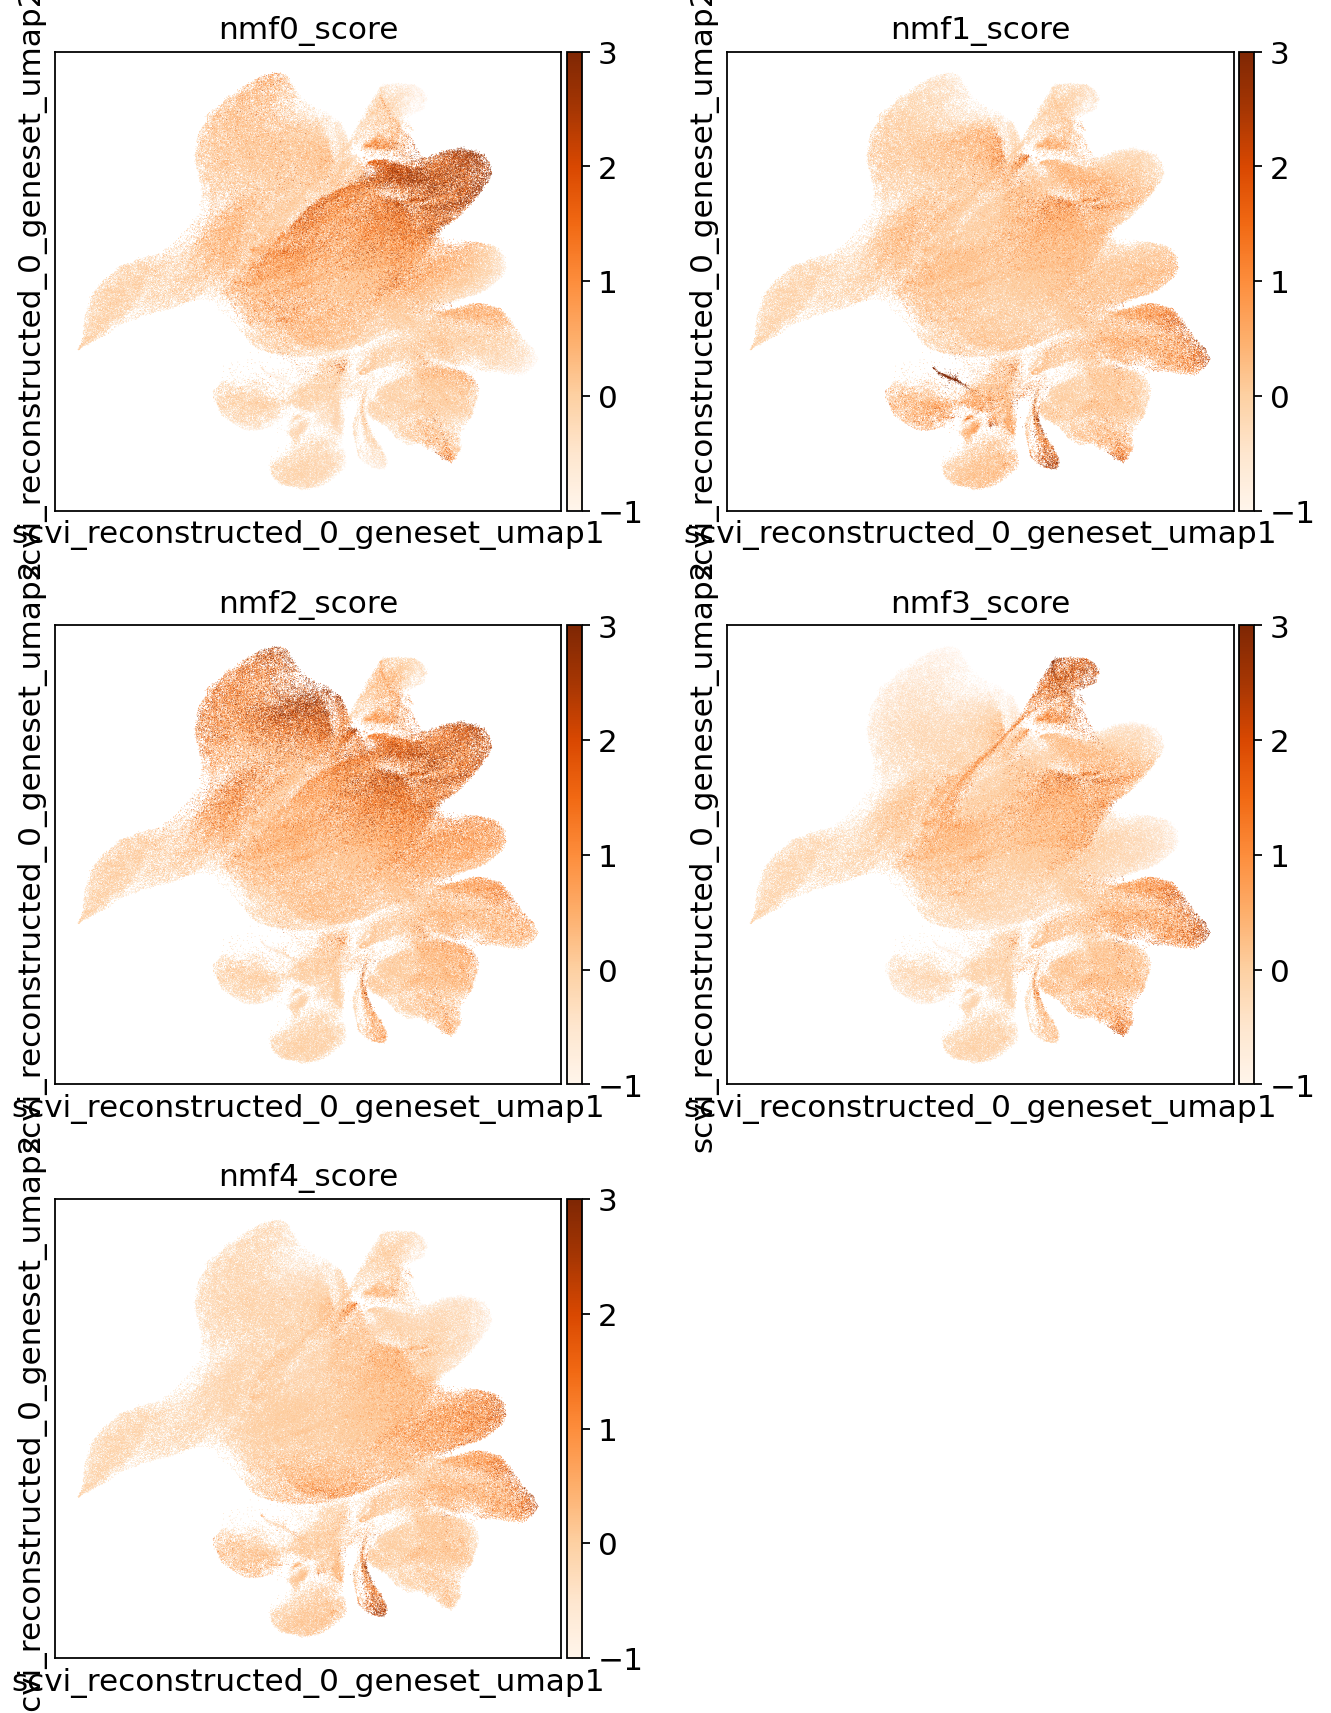

In [127]:
sc.pl.embedding(adata_glyco, basis='scvi_reconstructed_0_geneset_umap', 
                color=[c for c in adata_glyco.obs.columns if c.startswith('nmf') and c.endswith('_score')], 
                cmap='Oranges', vmin=-1, vmax=3, ncols=2)

In [ ]:
sc.pl.embedding(adata_glyco, basis='scvi_reconstructed_0_geneset_umap', color=['cell_type'])